In [1]:
import pandas as pd
import numpy as np
import os
import time
from astropy.cosmology import Planck13
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

import disperse

from sklearn.neighbors import KDTree
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
cosmo = Planck13
H0 = cosmo.H0.value
Om = cosmo.Om0
Ol = 0.69288
Ok = 0.0
print(f'H0 = {cosmo.H0.value}')
print(f'Om = {cosmo.Om0}')
print(f'Ol = {0.69288}')

H0 = 67.77
Om = 0.30712
Ol = 0.69288


In [3]:
import pickle

In [4]:
with open('srclist_lockman_032_wvsh.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
data

,ID_SRC,RA,DEC,RADEC_ERR,EXT,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,EXT_LIKE,EXT_ERR,...,TSTOP,ML_EXP_1,APE_CTS_1,APE_BKG_1,APE_EXP_1,APE_EEF_1,APE_RADIUS_1,APE_POIS_1,RA_corr,DEC_corr
0,1,159.435510,57.198784,0.000000,0.000000,66750.085938,6.003547,2.523368,0.00000,0.000000,...,6.278688e+08,4871.123535,10428,14.270072,4870.865723,0.75,7.567884,0.000000,159.435370,57.198305
1,4494,164.608920,56.792861,0.000000,61.917984,1255.998169,2.845616,0.117522,403.74115,2.159959,...,6.278688e+08,781.437988,310,5.338651,782.237305,0.75,10.326495,0.000000,164.608780,56.792382
2,5,164.273234,58.077511,0.000000,0.000000,12358.708008,1.725359,0.764377,0.00000,0.000000,...,6.278688e+08,4826.105957,2642,13.689127,4825.153320,0.75,7.414415,0.000000,164.273094,58.077032
3,60,165.406673,57.491154,0.455702,0.000000,4928.606934,1.455636,0.044620,0.00000,0.000000,...,6.278688e+08,810.286499,909,3.674417,811.295105,0.75,10.214846,0.000000,165.406533,57.490675
4,4,166.406711,58.855927,0.246261,0.000000,14068.260742,1.441918,0.054748,0.00000,0.000000,...,6.278688e+08,2053.034180,2304,6.577723,2052.429688,0.75,7.917719,0.000000,166.406571,58.855448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8494,6212,155.836434,56.284402,3.276881,0.000000,8.493439,0.001906,0.000642,0.00000,0.000000,...,6.278688e+08,8058.040039,21,12.784801,8061.397949,0.75,5.642705,0.021427,155.836293,56.283923
8495,4451,160.883184,54.863436,3.520278,0.000000,7.994558,0.001858,0.000629,0.00000,0.000000,...,6.278688e+08,9023.207031,30,18.300381,9024.296875,0.75,6.462280,0.007378,160.883044,54.862957
8496,1694,160.930042,55.025946,4.273491,0.000000,6.765484,0.001818,0.000646,0.00000,0.000000,...,6.278688e+08,9252.168945,36,22.655256,9243.442383,0.75,7.039980,0.005829,160.929902,55.025467
8497,6914,161.200088,54.859166,3.911239,0.000000,6.506335,0.001811,0.000638,0.00000,0.000000,...,6.278688e+08,9293.346680,28,17.289949,9297.845703,0.75,6.206985,0.010835,161.199947,54.858687


In [6]:
data['RA'].min(), data['RA'].max()

(154.7626506540677, 167.09685093917133)

In [7]:
data['DEC'].min(), data['DEC'].max()

(54.267458818027215, 61.25285661021501)

In [8]:
data[data['EXT_LIKE'] > 0]

,ID_SRC,RA,DEC,RADEC_ERR,EXT,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,EXT_LIKE,EXT_ERR,...,TSTOP,ML_EXP_1,APE_CTS_1,APE_BKG_1,APE_EXP_1,APE_EEF_1,APE_RADIUS_1,APE_POIS_1,RA_corr,DEC_corr
1,4494,164.608920,56.792861,0.000000,61.917984,1255.998169,2.845616,0.117522,403.741150,2.159959,...,6.278688e+08,781.437988,310,5.338651,782.237305,0.75,10.326495,0.000000e+00,164.608780,56.792382
5,4236,164.542737,56.758416,0.000000,92.512520,201.090210,1.102708,0.102276,61.102184,5.957702,...,6.278688e+08,848.569397,64,5.489577,832.470581,0.75,10.218180,7.006492e-45,164.542597,56.757937
11,548,161.304824,58.144552,2.310791,42.419319,2784.219727,0.659592,0.019024,977.559204,1.294162,...,6.278688e+08,4887.219727,470,15.505969,4887.909180,0.75,7.571466,0.000000e+00,161.304683,58.144073
12,119,164.380062,57.993879,1.145211,22.034355,2786.380615,0.630641,0.015839,722.510925,0.826146,...,6.278688e+08,4679.162598,1081,13.731589,4678.761230,0.75,7.330606,0.000000e+00,164.379922,57.993400
13,29,160.251532,58.302621,0.000000,105.148270,223.150375,0.597084,0.049762,70.509407,5.488338,...,6.278688e+08,4862.271484,146,14.847513,4870.322754,0.75,7.559626,0.000000e+00,160.251392,58.302142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,7685,162.137056,59.906592,6.584505,15.248463,26.779800,0.017807,0.003101,10.934018,4.007318,...,6.278688e+08,4908.875488,50,14.756679,4907.821289,0.75,7.438211,5.065403e-13,162.136916,59.906113
1562,4623,155.656687,56.519299,6.153666,15.804686,52.165356,0.017601,0.002391,16.804056,3.008349,...,6.278688e+08,7132.506836,51,11.515516,7136.909180,0.75,5.785284,1.100906e-17,155.656547,56.518820
1646,7847,160.070787,59.723114,0.000000,20.348000,21.462021,0.016925,0.003189,9.474149,4.967316,...,6.278688e+08,4784.395996,38,12.474102,4785.064453,0.75,7.513441,4.759097e-09,160.070646,59.722635
1927,7717,159.332195,58.829966,5.118139,15.385753,24.035006,0.014844,0.002775,8.240784,4.087005,...,6.278688e+08,4874.981445,49,13.801598,4878.205566,0.75,7.570659,1.650315e-13,159.332055,58.829487


In [9]:
galaxies = pd.read_csv('SDSS/SDSS_DR16.csv')

In [10]:
galaxies

,ra,dec,z,zErr,class,subClass
0,146.71421,-1.041304,0.021275,0.000009,GALAXY,NaN
1,146.71421,-1.041304,0.021222,0.000009,GALAXY,STARFORMING
2,146.91945,-0.990492,0.213925,0.000052,GALAXY,NaN
3,146.74413,-0.652191,0.203783,0.000039,GALAXY,NaN
4,146.90229,-0.984913,0.652181,0.000133,QSO,BROADLINE
...,...,...,...,...,...,...
5789195,146.33588,26.600093,0.727322,0.000239,QSO,NaN
5789196,146.12242,26.516686,2.240312,0.001260,QSO,NaN
5789197,146.32252,26.549261,0.058894,0.000007,GALAXY,STARBURST
5789198,146.24366,26.573191,0.580577,0.000214,GALAXY,NaN


In [11]:
gal_RA_int = (130, 190)
gal_DEC_int = (45, 72)
gal_Z_int = (0, 1.0)

In [12]:
galaxies = pd.read_csv('SDSS/SDSS_DR16.csv')
galaxies = galaxies[galaxies['class'] == 'GALAXY']
galaxies = galaxies[(gal_RA_int[0] <= galaxies['ra']) & (galaxies['ra'] <= gal_RA_int[1])]
galaxies = galaxies[(gal_DEC_int[0] <= galaxies['dec']) & (galaxies['dec'] <= gal_DEC_int[1])]
galaxies = galaxies[(gal_Z_int[0] < galaxies['z']) & (galaxies['z'] <= gal_Z_int[1])]
galaxies = galaxies[['ra', 'dec', 'z']]
galaxies.columns = ['RA', 'DEC', 'Z']
galaxies.drop_duplicates(subset=['RA', 'DEC', 'Z'])
galaxies.reset_index(drop=True, inplace=True)
# galaxies

In [13]:
util_DPS = disperse.Disperse3D(
    galaxies, '_disperse_03/bin/',
    H0, Om, Ol, Ok,
    clusters=None
)

In [14]:
CX, CY, CZ = util_DPS.sph2cart(galaxies['RA'], galaxies['DEC'], galaxies['Z'])
galaxies['CX'] = CX
galaxies['CY'] = CY
galaxies['CZ'] = CZ
galaxies

,RA,DEC,Z,CX,CY,CZ
0,130.08993,52.178072,0.097629,-166.646393,197.969562,333.343396
1,130.03945,52.455980,0.016566,-28.617372,34.057206,57.880854
2,130.17394,52.557722,0.067737,-115.664731,136.997069,234.149223
3,130.08130,52.668127,0.063350,-107.808680,128.111764,219.539752
4,130.29167,52.572328,0.065425,-112.013047,132.120187,226.326283
...,...,...,...,...,...,...
223055,181.07445,45.038743,0.610079,-1627.977545,-30.532538,1630.467368
223056,181.11007,45.024374,0.754221,-1935.438087,-37.502599,1937.449099
223057,181.22110,45.169607,0.925820,-2262.049194,-48.216580,2275.998105
223058,181.34912,45.030762,0.873563,-2169.804522,-51.100933,2172.738003


In [15]:
# DPS = disperse.Disperse3D(
#     galaxies, '_disperse_03/bin/',
#     H0, Om, Ol, Ok,
#     clusters=None
# )

In [16]:
# DPS.count_cart_coords()

In [17]:
# SIGMA = 5.0
# SMOOTH = 1
# BOARD = 'smooth'
# ANGLE = 30

In [18]:
sigmas = [
         0.2, 0.4, 0.6, 0.8,
    1.0, 1.2, 1.4, 1.6, 1.8,
    2.0, 2.2, 2.4, 2.6, 2.8,
    3.0, 3.2, 3.4, 3.6, 3.8, 
    4.0, 4.2, 4.4, 4.6, 4.8, 
    5.0, 5.2, 5.4, 5.6, 5.8, 
    6.0, 6.2, 6.4, 6.6, 6.8,
    7.0, 7.2, 7.4, 7.6, 7.8,
    8.0, 8.2, 8.4, 8.6, 8.8,
    9.0, 9.2, 9.4, 9.6, 9.8,
    10.0, 10.2, 10.4, 10.6, 10.8,
    11.0, 11.2, 11.4, 11.6, 11.8,
    12.0, 12.2, 12.4, 12.6, 12.8,
    13.0, 13.2, 13.4, 13.6, 13.8,
    14.0
]

In [19]:
# for sigma in sigmas:
#     SIGMA = sigma
#     print('### ', SIGMA)
#     DPS.apply_disperse(SIGMA, SMOOTH, BOARD, ANGLE)
#     DPS.save(f'lockman_dumps/{SIGMA}/')

In [20]:
clusters = data #[data['EXT_LIKE'] > 0]
clusters['R'] = [0] * clusters.shape[0]
clusters['ID'] = list(range(clusters.shape[0]))
clusters.reset_index(drop=True, inplace=True)
clusters

,ID_SRC,RA,DEC,RADEC_ERR,EXT,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,EXT_LIKE,EXT_ERR,...,APE_CTS_1,APE_BKG_1,APE_EXP_1,APE_EEF_1,APE_RADIUS_1,APE_POIS_1,RA_corr,DEC_corr,R,ID
0,1,159.435510,57.198784,0.000000,0.000000,66750.085938,6.003547,2.523368,0.00000,0.000000,...,10428,14.270072,4870.865723,0.75,7.567884,0.000000,159.435370,57.198305,0,0
1,4494,164.608920,56.792861,0.000000,61.917984,1255.998169,2.845616,0.117522,403.74115,2.159959,...,310,5.338651,782.237305,0.75,10.326495,0.000000,164.608780,56.792382,0,1
2,5,164.273234,58.077511,0.000000,0.000000,12358.708008,1.725359,0.764377,0.00000,0.000000,...,2642,13.689127,4825.153320,0.75,7.414415,0.000000,164.273094,58.077032,0,2
3,60,165.406673,57.491154,0.455702,0.000000,4928.606934,1.455636,0.044620,0.00000,0.000000,...,909,3.674417,811.295105,0.75,10.214846,0.000000,165.406533,57.490675,0,3
4,4,166.406711,58.855927,0.246261,0.000000,14068.260742,1.441918,0.054748,0.00000,0.000000,...,2304,6.577723,2052.429688,0.75,7.917719,0.000000,166.406571,58.855448,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8494,6212,155.836434,56.284402,3.276881,0.000000,8.493439,0.001906,0.000642,0.00000,0.000000,...,21,12.784801,8061.397949,0.75,5.642705,0.021427,155.836293,56.283923,0,8494
8495,4451,160.883184,54.863436,3.520278,0.000000,7.994558,0.001858,0.000629,0.00000,0.000000,...,30,18.300381,9024.296875,0.75,6.462280,0.007378,160.883044,54.862957,0,8495
8496,1694,160.930042,55.025946,4.273491,0.000000,6.765484,0.001818,0.000646,0.00000,0.000000,...,36,22.655256,9243.442383,0.75,7.039980,0.005829,160.929902,55.025467,0,8496
8497,6914,161.200088,54.859166,3.911239,0.000000,6.506335,0.001811,0.000638,0.00000,0.000000,...,28,17.289949,9297.845703,0.75,6.206985,0.010835,161.199947,54.858687,0,8497


In [35]:
clusters.columns

Index(['ID_SRC', 'RA', 'DEC', 'RADEC_ERR', 'EXT', 'DET_LIKE_0', 'ML_FLUX_0',
       'ML_FLUX_ERR_0', 'EXT_LIKE', 'EXT_ERR', 'ID_CLUSTER', 'DIST_NN',
       'ML_CTS_0', 'ML_CTS_ERR_0', 'ML_BKG_0', 'SRCDENS', 'TSTART', 'TSTOP',
       'ML_EXP_1', 'APE_CTS_1', 'APE_BKG_1', 'APE_EXP_1', 'APE_EEF_1',
       'APE_RADIUS_1', 'APE_POIS_1', 'RA_corr', 'DEC_corr', 'R', 'ID'],
      dtype='object')

In [21]:
z = [round(i, 4) for i in np.arange(0.02, 0.602, 0.002)]

ID, RA, DEC, Z, R = [], [], [], [], []
for i in range(clusters.shape[0]):
    row = clusters.iloc[i]
    ID = ID + [int(row['ID'])] * len(z)
    RA = RA + [row['RA']] * len(z)
    DEC = DEC + [row['DEC']] * len(z)
    Z = Z + z.copy()
    R = R + [row['R']] * len(z)
CX, CY, CZ = util_DPS.sph2cart(RA, DEC, Z)
clusters_ext = pd.DataFrame({
    'ID': ID, 'RA': RA, 'DEC': DEC, 'Z': Z,
    'CX': CX, 'CY': CY, 'CZ': CZ,
    'R': R
})

clusters_ext

,ID,RA,DEC,Z,CX,CY,CZ,R
0,0,159.435510,57.198784,0.020,-44.666722,16.757530,74.022884,0.0
1,0,159.435510,57.198784,0.022,-49.110465,18.424681,81.387174,0.0
2,0,159.435510,57.198784,0.024,-53.550021,20.090260,88.744524,0.0
3,0,159.435510,57.198784,0.026,-57.985384,21.754267,96.094927,0.0
4,0,159.435510,57.198784,0.028,-62.416551,23.416700,103.438375,0.0
...,...,...,...,...,...,...,...,...
2473204,8498,161.403945,54.771317,0.592,-1228.516256,413.347230,1835.514737,0.0
2473205,8498,161.403945,54.771317,0.594,-1231.994085,414.517382,1840.710929,0.0
2473206,8498,161.403945,54.771317,0.596,-1235.467712,415.686121,1845.900844,0.0
2473207,8498,161.403945,54.771317,0.598,-1238.937143,416.853447,1851.084488,0.0


In [22]:
def gen_feas(galaxies, clusters):
    cl_coords = np.array([
        clusters['CX'].values,
        clusters['CY'].values,
        clusters['CZ'].values
    ]).T
    
    g_coords = np.array([
        galaxies['CX'].values,
        galaxies['CY'].values,
        galaxies['CZ'].values
    ]).T
    kd_tree = KDTree(g_coords)
    
    cme_rads = [0.2, 0.5, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0, 7.5, 10.0, 12.0]
    cmd = []
    mi = []
    enc = []
    
    for r in tqdm(cme_rads):
        nn_idx, nn_dists = kd_tree.query_radius(cl_coords, r=r, return_distance=True)
        t_cmd = []
        t_mi = []
        t_enc = []
        for i, idx in enumerate(nn_idx):
            if len(idx) == 0:
                continue
            if nn_dists[i].min() < 0.01:
                nn_idx[i] = np.delete(nn_idx[i], nn_dists[i].argmin())
                nn_dists[i] = np.delete(nn_dists[i], nn_dists[i].argmin())
        for i, idx in enumerate(nn_idx):
            if len(idx) == 0:
                t_cmd.append(-1)
                t_mi.append(0)
                t_enc.append(0)
                continue
            t_enc.append(len(idx))
            nn_coords = g_coords[idx]
            mass_center = nn_coords.mean(0)
            t_cmd.append((((cl_coords[i] - mass_center)**2).sum())**0.5)
            t_mi.append((nn_dists[i]**2).sum())
        cmd.append(t_cmd)
        mi.append(t_mi)
        enc.append(t_enc)
    
    cmd = np.array(cmd).T
    mi = np.array(mi).T
    enc = np.array(enc).T
    
    knn_num = [1, 2, 3, 5, 8, 10, 15, 20, 25, 30, 35, 40]
    knn = []
    
    for n in tqdm(knn_num):
        nn_idx, nn_dists = kd_tree.query(cl_coords, k=n+1)
        t_knn = []
        for d in nn_dists:
            if d[n-1] >= 0.01:
                t_knn.append(d[n-1])
            else:
                t_knn.append(d[n])
        knn.append(t_knn)
    
    knn = np.array(knn).T
    
    _pca = PCA(n_components=3)
    pca_rads = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
    pca = []
    
    for r in tqdm(pca_rads):
        nn_idx, nn_dists = kd_tree.query_radius(cl_coords, r=r, return_distance=True)
        t_pca = []
        for i, idx in enumerate(nn_idx):
            if len(idx) == 0:
                continue
            if nn_dists[i].min() < 0.01:
                nn_idx[i] = np.delete(nn_idx[i], nn_dists[i].argmin())
                nn_dists[i] = np.delete(nn_dists[i], nn_dists[i].argmin())
        for i, idx in enumerate(nn_idx):
            if len(idx) < 3:
                t_pca.append(-1)
                continue
            nn_coords = g_coords[idx]
            _pca.fit(nn_coords)
            var_ratio = _pca.explained_variance_ratio_
            t_pca.append(max(var_ratio) - min(var_ratio))
        pca.append(t_pca)
    
    pca = np.array(pca).T
    
    feas = np.concatenate([cmd, mi, enc, knn, pca], axis=1)
    
    return feas

In [23]:
f_name = 'lockman_dists_ext.npy'
if os.path.exists(f_name):
    with open(f_name, 'rb') as f:
        dists_ext = np.load(f)
else:
    dists_ext = []
    for sigma in tqdm(sigmas):
        DPS = disperse.Disperse3D.read(f'lockman_dumps/{sigma}/')

        _, _, cl_dists \
            = DPS.count_conn(clusters_ext['R'], clusters_ext)
        dists_ext.append(np.array(cl_dists)[None,:])
    dists_ext = np.concatenate(dists_ext, axis=0)
    dists_ext = dists_ext.T
    with open(f_name, 'wb') as f:
        np.save(f, dists_ext)

print(dists_ext.shape)

(2473209, 70)


In [24]:
dens_feas_ext = gen_feas(galaxies, clusters_ext)

100%|██████████| 6/6 [01:10<00:00, 11.72s/it]


In [25]:
feas_ext = np.concatenate((
    dists_ext, 
    clusters_ext['Z'].values.reshape(-1, 1),
    dens_feas_ext
), axis=1)

In [26]:
boostings = []
boostings.append(lgbm.Booster(model_file='boosting_01.txt'))
boostings.append(lgbm.Booster(model_file='boosting_02.txt'))

In [27]:
boosting_scores_ext = np.zeros(clusters_ext.shape[0])
for i in range(len(boostings)):
    boosting_scores_ext += boostings[i].predict(feas_ext) #[:,1].reshape(-1)
boosting_scores_ext /= len(boostings)

In [28]:
boosting_scores_ext

array([0.06685358, 0.01781599, 0.093511  , ..., 0.03401408, 0.00445204,
       0.00278608])

In [29]:
clusters_ext['boosting_score'] = boosting_scores_ext

In [30]:
boosting_scores_ext_lvl2 = np.zeros(clusters.shape[0])
boosting_pred_z_ext_lvl2 = np.zeros(clusters.shape[0])
for id_ in range(clusters.shape[0]):
    boosting_scores_ext_lvl2[id_] = clusters_ext[clusters_ext['ID'] == id_]['boosting_score'].max()

No handles with labels found to put in legend.


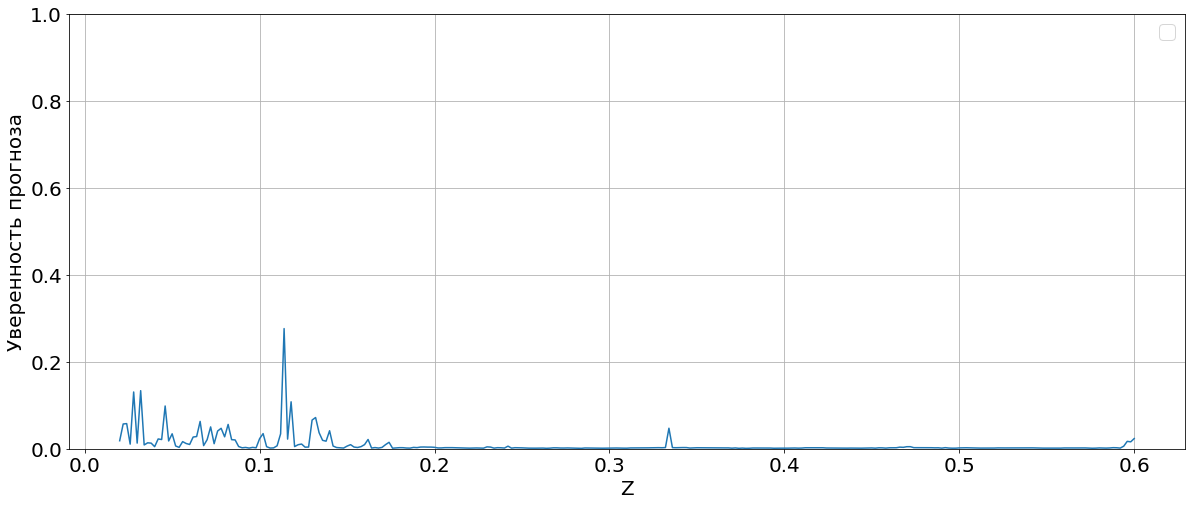

In [31]:
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 8))
plt.grid()
plt.ylim(0, 1)

ID = 2

plt.plot(
    clusters_ext[clusters_ext['ID'] == ID]['Z'],
    clusters_ext[clusters_ext['ID'] == ID]['boosting_score'],
#     label='boosting_score'
)

# plt.plot(
#     clusters_ext[clusters_ext['ID'] == ID]['Z_true'].iloc[0], 
#     1, 'ro', markersize=12
# )
# plt.vlines(
#     clusters_ext[clusters_ext['ID'] == ID]['Z_true'].iloc[0],
#     0, 1, colors='r', linestyles='--', linewidth=2, alpha=0.7, label='местоположение кластера'
# )

plt.xlabel('Z')
plt.ylabel('Уверенность прогноза')
plt.legend()

In [32]:
y = (clusters['EXT'] > 0).astype(int).values

In [33]:
y

array([0, 1, 0, ..., 0, 0, 0])

In [34]:
roc_auc_score(y, boosting_scores_ext_lvl2)

0.5767857938736398